In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

'''
1번 스토리:
등/하원때마다 성수역 앞의 따릉이가 쌓여있는것을 보고
따릉이를 필요한곳에 더, 반납이 많은곳엔 덜 배치해서 따릉이의 이용률을 더 높힐 수 있을까? 라는 의문점에서 출발.

1. 대여소 번호가 많은 순으로 랭킹을 선정해서 수요가 가장 많았던 스테이션을 추려내고
2. 반대로 반납 대여소를 카운트해서 가장 많았던 스테이션도 추려내서

수요가 많은 곳에는 따릉이를 더 배치하고, 반납이 많았던 곳에는 따르이 배치를 덜 해서
효율성과 경제성을 도모 할 수 있는 인사이트 제시




2번 스토리:
코로나팬대믹 이후로 사람들은 따릉이를 더 탈까 덜 탈까?
재택근무의 확대로 유동자체가 적어져서 따릉이 이용 횟수가 적어졌을까?
아니면 팬대믹으로 대중교통 이용에 불안감이 조성되어 따릉이로 출퇴근을 해서 더 많아졌을까?
라는 궁금점에서 출발.

7월과 8월의 비교
1. 19년도 7월과 20년도 7월의 이용량 비교 (코로나의 영향이 있는지)
2. 위 지표들간의 이용시간의 차이, 이용거리의 변화도 있는지 확인.


extra)
풍속, 가시거리, 미세먼지, 초미세먼지, 강수여부, 요일, 휴일여부 등에 대한 수치들을 수집해서 모델링 후
따릉이 수가 부족할것으로 예상되는곳, 따릉이의 반납이 집중될 곳을 예측

계절별, 시간대별 분류
신형따릉이 구형따릉이 미니따릉이에 대한 이용분석
'''

'\n1번 스토리:\n등/하원때마다 성수역 앞의 따릉이가 쌓여있는것을 보고\n따릉이를 필요한곳에 더, 반납이 많은곳엔 덜 배치해서 따릉이의 이용률을 더 높힐 수 있을까? 라는 의문점에서 출발.\n\n1. 대여소 번호가 많은 순으로 랭킹을 선정해서 수요가 가장 많았던 스테이션을 추려내고\n2. 반대로 반납 대여소를 카운트해서 가장 많았던 스테이션도 추려내서\n\n수요가 많은 곳에는 따릉이를 더 배치하고, 반납이 많았던 곳에는 따르이 배치를 덜 해서\n효율성과 경제성을 도모 할 수 있는 인사이트 제시\n\n\n\n\n2번 스토리:\n코로나팬대믹 이후로 사람들은 따릉이를 더 탈까 덜 탈까?\n재택근무의 확대로 유동자체가 적어져서 따릉이 이용 횟수가 적어졌을까?\n아니면 팬대믹으로 대중교통 이용에 불안감이 조성되어 따릉이로 출퇴근을 해서 더 많아졌을까?\n라는 궁금점에서 출발.\n\n7월과 8월의 비교\n1. 19년도 7월과 20년도 7월의 이용량 비교 (코로나의 영향이 있는지)\n2. 위 지표들간의 이용시간의 차이, 이용거리의 변화도 있는지 확인.\n\n\nextra)\n풍속, 가시거리, 미세먼지, 초미세먼지, 강수여부, 요일, 휴일여부 등에 대한 수치들을 수집해서 모델링 후\n따릉이 수가 부족할것으로 예상되는곳, 따릉이의 반납이 집중될 곳을 예측\n\n계절별, 시간대별 분류\n신형따릉이 구형따릉이 미니따릉이에 대한 이용분석\n'

In [58]:
station = pd.read_csv('./datas/location.csv',encoding='cp949')

In [8]:
# 자전거번호, 대여일시, 대여 대여소번호,대여 대여소명, 반납일시, 반납대여소번호, 반납대여소 이름, 이용시간, 이용거리
# csv 파일의 컬럼을 사용할 컬럼만 선택하고 나머지는 drop
def using_change(df):
    df = df.drop(['대여거치대','반납거치대'], axis=1)
    df.columns=['bicycle_type','rental_dt','rental_station_num ','rental_station_name','return_dt','return_station_num','return_station_name','using_time','using_distance']
    return df
    

In [9]:
# 대여소번호, 보관소(대여소)명, 소재지, longitude, latitude
# csv 파일의 컬럼을 사용할 컬럼만 선택하고 나머지는 drop
def station_change(df):
    df = df.drop(['Unnamed: 3','설치\n시기','설치형태','Unnamed: 8','운영\n방식'],axis=1)
    df.columns=['station_num','station_name','location','longitude','latitude']
    return df
    

In [64]:
station

,대여소\n번호,보관소(대여소)명,소재지(위치),Unnamed: 3,Unnamed: 4,Unnamed: 5,설치\n시기,설치형태,Unnamed: 8,운영\n방식
4,301.0,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16,NaN,LCD
5,302.0,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12,NaN,LCD
6,303.0,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8,NaN,LCD
7,304.0,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,NaN,7,QR
8,305.0,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16,NaN,LCD
...,...,...,...,...,...,...,...,...,...,...
2153,1085.0,래미안 솔베뉴(고덕로),강동구,양재대로1650,37.554569,127.145874,2020-01-13,NaN,20,QR
2154,1086.0,래미안 솔베뉴(구천면로),강동구,양재대로1650,37.550598,127.145454,2020-01-10,NaN,10,QR
2155,1088.0,풍납사거리(강동),강동구,성내동451-3,37.528122,127.119522,2020-01-14,NaN,12,QR
2156,1089.0,고덕 래미안힐스테이트(201동),강동구,고덕동 675,37.560600,127.146698,2020-01-13,NaN,10,QR


In [6]:
# 2019/07 데이터 불러오기
sb1907_1 = pd.read_csv('./data/seoul_bike_201907_1.csv',encoding='cp949')
# sb1907_2 = pd.read_csv('./data/seoul_bike_201907_2.csv',encoding='cp949')
# sb1907_3 = pd.read_csv('./data/seoul_bike_201907_3.csv',encoding='cp949')

# # 2019/08 데이터 불러오기
# sb1908_1 = pd.read_csv('./data/seoul_bike_201908_1.csv',encoding='cp949')
# sb1908_2 = pd.read_csv('./data/seoul_bike_201908_2.csv',encoding='cp949')
# sb1908_3 = pd.read_csv('./data/seoul_bike_201908_3.csv',encoding='cp949')

In [7]:
sb1907_1

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),4,2019-07-02 08:42:31,3,중랑센터,2,6,1350.0
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2,2019-07-03 08:42:28,3,중랑센터,2,7,1160.0
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2,2019-07-03 09:09:44,3,중랑센터,14,23,1270.0
3,SPB-21930,2019-07-04 08:49:57,646,장한평역 1번출구 (국민은행앞),4,2019-07-04 09:04:17,3,중랑센터,14,14,1290.0
4,SPB-17709,2019-07-05 08:45:03,529,장한평역 8번 출구 앞,12,2019-07-05 09:11:47,3,중랑센터,14,26,1200.0
...,...,...,...,...,...,...,...,...,...,...,...
799995,SPB-11568,2019-07-22 20:28:29,844,이촌2동 동원베네스트 아파트 앞,10,2019-07-22 20:42:38,823,효창동주민센터 앞,9,14,2370.0
799996,SPB-24122,2019-07-22 20:19:27,119,서강나루 공원,2,2019-07-22 20:44:40,823,효창동주민센터 앞,6,24,4450.0
799997,SPB-22506,2019-07-22 21:32:46,819,선린인터넷 고등학교,2,2019-07-22 21:41:25,823,효창동주민센터 앞,1,8,1170.0
799998,SPB-24122,2019-07-22 21:09:04,823,효창동주민센터 앞,6,2019-07-22 23:04:52,823,효창동주민센터 앞,4,112,8960.0


In [10]:
using_change(sb1907_1)

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),2019-07-02 08:42:31,3,중랑센터,6,1350.0
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2019-07-03 08:42:28,3,중랑센터,7,1160.0
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2019-07-03 09:09:44,3,중랑센터,23,1270.0
3,SPB-21930,2019-07-04 08:49:57,646,장한평역 1번출구 (국민은행앞),2019-07-04 09:04:17,3,중랑센터,14,1290.0
4,SPB-17709,2019-07-05 08:45:03,529,장한평역 8번 출구 앞,2019-07-05 09:11:47,3,중랑센터,26,1200.0
...,...,...,...,...,...,...,...,...,...
799995,SPB-11568,2019-07-22 20:28:29,844,이촌2동 동원베네스트 아파트 앞,2019-07-22 20:42:38,823,효창동주민센터 앞,14,2370.0
799996,SPB-24122,2019-07-22 20:19:27,119,서강나루 공원,2019-07-22 20:44:40,823,효창동주민센터 앞,24,4450.0
799997,SPB-22506,2019-07-22 21:32:46,819,선린인터넷 고등학교,2019-07-22 21:41:25,823,효창동주민센터 앞,8,1170.0
799998,SPB-24122,2019-07-22 21:09:04,823,효창동주민센터 앞,2019-07-22 23:04:52,823,효창동주민센터 앞,112,8960.0


In [260]:
# 2020/07_8 데이터 불러오기
sb2007_08 = pd.read_csv('./datas/seoul_bicycle_2020.07_08.csv',encoding='cp949')

In [188]:
# 19년 7~8월 데이터 컬럼명 변경하기
sb1907_1 = using_change(sb1907_1)
sb1907_2 = using_change(sb1907_2)
sb1907_3 = using_change(sb1907_3)

sb1908_1 = using_change(sb1908_1)
sb1908_2 = using_change(sb1908_2)
sb1908_3 = using_change(sb1908_3)

In [261]:
# 20년 7~8월 데이터 컬럼명 변경하기
sb2007_08 = using_change(sb2007_08)

In [190]:
# 나눠져있는 1907/1908 데이터 concat으로 합치기
sb1907 = pd.concat([sb1907_1,sb1907_2,sb1907_3])
sb1907.reset_index(inplace=True,drop=True)
sb1907

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),2019-07-02 08:42:31,3,중랑센터,6,1350.0
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2019-07-03 08:42:28,3,중랑센터,7,1160.0
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2019-07-03 09:09:44,3,중랑센터,23,1270.0
3,SPB-21930,2019-07-04 08:49:57,646,장한평역 1번출구 (국민은행앞),2019-07-04 09:04:17,3,중랑센터,14,1290.0
4,SPB-17709,2019-07-05 08:45:03,529,장한평역 8번 출구 앞,2019-07-05 09:11:47,3,중랑센터,26,1200.0
...,...,...,...,...,...,...,...,...,...
2082606,SPB-20127,2019-07-19 07:41:34,240,문래역 4번출구 앞,2019-07-19 07:51:55,9998,영남주차장 정비센터,9,480.0
2082607,SPB-23276,2019-07-19 07:50:48,832,이촌1동 주민센터 뒤,2019-07-19 08:32:51,9998,영남주차장 정비센터,40,8840.0
2082608,SPB-17321,2019-07-22 12:43:22,266,영등포청과시장 사거리,2019-07-22 13:07:29,9998,영남주차장 정비센터,23,3320.0
2082609,SPB-22044,2019-07-22 12:43:13,266,영등포청과시장 사거리,2019-07-22 13:08:53,9998,영남주차장 정비센터,25,2960.0


### 나눠져있는 데이터 concat으로 합치기
sb1908 = pd.concat([sb1908_1,sb1908_2,sb1908_3])
sb1908.reset_index(inplace=True,drop=True)
sb1908

In [234]:
sb2007_08[1353291:1353292]

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
1353291,SPB-31470,2020-08-01 00:00:01,714,한국SGI 양천문화회관 앞,2020-08-01 00:03:47,740,으뜸공원,4,0.0


In [192]:
sb2007 = sb2007_08[:1353291]
sb2008 = sb2007_08[1353292:]

In [229]:
Q = []
W = []
for q in list(sb2007_08[1341292:1364292]['rental_dt']):
    Q.append(q.split(' '))
for w in Q:
    W.append(w[0])

['2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-31',
 '2020-07-

In [233]:
W[22950:]

['2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01',
 '2020-08-01']

In [193]:
sb2008.reset_index(inplace=True,drop=True)
sb2007.reset_index(inplace=True,drop=True)

In [194]:
sb2007

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-11402,2020-07-01 00:00:15,610,동대문중 교차로,2020-07-01 00:03:23,657,동대문롯데캐슬아파트 앞,3,450.00
1,SPB-32502,2020-07-01 00:00:40,1707,도봉구민회관,2020-07-01 00:04:30,1775,신원리베르텔 앞,4,0.00
2,SPB-33694,2020-07-01 00:00:17,2312,청담역 13번 출구 앞,2020-07-01 00:05:10,2313,금원빌딩 앞,5,492.63
3,SPB-32022,2020-07-01 00:02:07,2724,(재)FITI시험연구원,2020-07-01 00:05:24,2724,(재)FITI시험연구원,3,0.00
4,SPB-31475,2020-07-01 00:01:56,1436,영풍마드레빌,2020-07-01 00:05:35,1402,금란주차장 앞,4,222.39
...,...,...,...,...,...,...,...,...,...
1353286,SPB-34167,2020-07-31 23:40:19,2524,반포쇼핑타운 8동 앞,2020-08-01 00:03:42,837,한남나들목 입구,23,0.00
1353287,SPB-32240,2020-07-31 22:53:36,475,유어스,2020-08-01 00:03:42,475,유어스,70,0.00
1353288,SPB-30784,2020-07-31 22:50:33,787,양천아파트 입구,2020-08-01 00:03:43,787,양천아파트 입구,73,0.00
1353289,SPB-31697,2020-07-31 23:55:52,559,왕십리역 4번 출구 건너편,2020-08-01 00:03:44,519,양지사거리,8,0.00


In [195]:
sb2008

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-33520,2020-07-31 23:29:40,1286,위례중앙푸르지오 1단지 앞,2020-08-01 00:03:48,2377,수서역 5번출구 뒤,34,0.0
1,SPB-30552,2020-07-31 23:55:19,787,양천아파트 입구,2020-08-01 00:03:52,779,양천나눔누리센터,9,0.0
2,SPB-32425,2020-07-31 23:35:46,2720,힐스테이트에코,2020-08-01 00:03:53,1139,용문사 버스정류장,28,0.0
3,SPB-32685,2020-07-31 23:56:44,537,한양대후문역 부근,2020-08-01 00:03:56,631,답십리역 1번출구,7,0.0
4,SPB-33899,2020-07-31 22:30:50,116,일진아이윌아파트 옆,2020-08-01 00:03:56,3010,홍대입구역 3번출구,93,0.0
...,...,...,...,...,...,...,...,...,...
900780,SPB-34187,2020-08-31 23:48:10,841,신용산역 1번 출구,2020-09-01 03:05:26,2220,반포본동 주민센터 앞,197,0.0
900781,SPB-31279,2020-08-31 21:08:23,1159,서서울모터리움앞,2020-09-01 03:13:03,1103,방화역 4번출구앞,365,0.0
900782,SPB-30443,2020-08-31 23:02:51,242,신길선원가와인아파트 앞,2020-09-01 03:22:42,241,신길우성1차아파트 앞 공원,260,0.0
900783,SPB-31171,2020-08-31 21:26:58,726,목동3단지 시내버스정류장,2020-09-01 03:42:35,243,이앤씨드림타워 앞,376,0.0


In [63]:
station

,대여소\n번호,보관소(대여소)명,소재지(위치),Unnamed: 3,Unnamed: 4,Unnamed: 5,설치\n시기,설치형태,Unnamed: 8,운영\n방식
4,301.0,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16,NaN,LCD
5,302.0,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12,NaN,LCD
6,303.0,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8,NaN,LCD
7,304.0,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,NaN,7,QR
8,305.0,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16,NaN,LCD
...,...,...,...,...,...,...,...,...,...,...
2153,1085.0,래미안 솔베뉴(고덕로),강동구,양재대로1650,37.554569,127.145874,2020-01-13,NaN,20,QR
2154,1086.0,래미안 솔베뉴(구천면로),강동구,양재대로1650,37.550598,127.145454,2020-01-10,NaN,10,QR
2155,1088.0,풍납사거리(강동),강동구,성내동451-3,37.528122,127.119522,2020-01-14,NaN,12,QR
2156,1089.0,고덕 래미안힐스테이트(201동),강동구,고덕동 675,37.560600,127.146698,2020-01-13,NaN,10,QR


In [60]:
station = station[4:2158]

In [72]:
station = station_change(station)

In [84]:
mapo = station['location'] == '마포구'
MAPO = station[mapo]

In [90]:
station[station['location']=='마포구']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 4 to 2157
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_num   2154 non-null   float64
 1   station_name  2154 non-null   object 
 2   location      2154 non-null   object 
 3   longitude     2042 non-null   object 
 4   latitude      2042 non-null   object 
dtypes: float64(1), object(4)
memory usage: 84.3+ KB


In [97]:
# A = station['station_num'].astype(int)
B = station['location'].astype(str)

In [99]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 4 to 2157
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_num   2154 non-null   int64 
 1   station_name  2154 non-null   object
 2   location      2154 non-null   object
 3   longitude     2042 non-null   object
 4   latitude      2042 non-null   object
dtypes: int64(1), object(4)
memory usage: 84.3+ KB


In [102]:
station = station[station['location']=='마포구']

In [110]:
station = station.dropna()

In [144]:
mapo = station['station_num']

In [147]:
mapo = list(mapo)

# 마포구만 필터링

In [159]:
mapo

[101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 127,
 129,
 130,
 136,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 181,
 182,
 183,
 184,
 185,
 186,
 199,
 400,
 401,
 402,
 403,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 424,
 425,
 426,
 427,
 432,
 436,
 437,
 438,
 439,
 440,
 487,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 497,
 498,
 3002,
 3003,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 4202]

In [175]:
#각 이용데이터를 마포구의 station에서 빌린 데이터만 필터링
sb1907 = sb1907[sb1907['rental_station_num '].isin(mapo)]
sb1907.reset_index(inplace=True, drop=True)
sb1908 = sb1907[sb1908['rental_station_num '].isin(mapo)]
sb1908.reset_index(inplace=True, drop=True)
sb2007 = sb2007[sb2007['rental_station_num '].isin(mapo)]
sb2007.reset_index(inplace=True, drop=True)
sb2008 = sb2008[sb2008['rental_station_num '].isin(mapo)]
sb2008.reset_index(inplace=True, drop=True)


/Users/riversong/opt/anaconda3/envs/dss/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [178]:
sb1907

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-14205,2019-07-03 08:37:53,419,홈플러스 앞,2019-07-03 08:45:31,5,상암센터 정비실,5,0.0
1,SPB-01492,2019-07-05 08:25:30,184,SK망원동주유소 건너편,2019-07-05 08:33:15,5,상암센터 정비실,7,1520.0
2,SPB-07685,2019-07-01 01:58:42,102,망원역 1번출구 앞,2019-07-01 02:05:11,101,(구)합정동 주민센터,6,850.0
3,SPB-09058,2019-07-01 03:10:19,151,망원1동주민센터,2019-07-01 03:19:19,101,(구)합정동 주민센터,8,1060.0
4,SPB-03800,2019-07-01 08:23:42,199,서울 월드컵 경기장,2019-07-01 08:40:51,101,(구)합정동 주민센터,16,3920.0
...,...,...,...,...,...,...,...,...,...
144716,SPB-21347,2019-07-01 17:19:16,144,공덕역 8번출구,2019-07-01 18:35:43,3541,커먼그라운드,75,17080.0
144717,SPB-15547,2019-07-03 18:18:41,157,애오개역 4번출구 앞,2019-07-03 19:17:58,3541,커먼그라운드,58,12390.0
144718,SPB-04795,2019-07-14 18:47:50,105,합정역 5번출구 앞,2019-07-14 21:20:20,3541,커먼그라운드,152,0.0
144719,SPB-16459,2019-07-14 18:49:14,105,합정역 5번출구 앞,2019-07-14 21:20:22,3541,커먼그라운드,150,22890.0


In [179]:
sb1908

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-25398,2019-07-01 19:38:52,101,(구)합정동 주민센터,2019-07-01 20:36:41,101,(구)합정동 주민센터,55,8670.0
1,SPB-03998,2019-07-01 23:44:19,112,극동방송국 앞,2019-07-01 23:56:10,101,(구)합정동 주민센터,11,1880.0
2,SPB-05637,2019-07-02 02:12:10,151,망원1동주민센터,2019-07-02 02:17:09,101,(구)합정동 주민센터,4,1050.0
3,SPB-03483,2019-07-02 02:30:54,103,망원역 2번출구 앞,2019-07-02 02:36:30,101,(구)합정동 주민센터,5,1110.0
4,SPB-20645,2019-07-02 01:41:58,108,서교동 사거리,2019-07-02 02:41:14,101,(구)합정동 주민센터,55,1740.0
...,...,...,...,...,...,...,...,...,...
82034,SPB-19576,2019-07-12 18:36:48,113,홍대입구역 2번출구 앞,2019-07-12 20:21:19,3533,건대입구역 사거리(롯데백화점),102,20190.0
82035,SPB-06265,2019-07-11 21:25:59,112,극동방송국 앞,2019-07-11 23:08:52,3534,건대입구역 5번출구 뒤,102,19730.0
82036,SPB-22456,2019-07-06 21:43:10,129,신촌역(2호선) 6번출구 옆,2019-07-06 23:10:52,3535,중곡사거리(국민은행),87,19870.0
82037,SPB-23712,2019-07-02 21:09:45,118,광흥창역 2번출구 앞,2019-07-02 22:49:08,3536,중앙농협(자양동),95,81590.0


In [180]:
sb2007

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-31336,2020-07-01 00:07:48,402,상암월드컵파크 9단지 앞,2020-07-01 00:12:38,490,가온문화공원,5,637.06
1,SPB-30393,2020-07-01 00:06:29,401,상암월드컵파크 10단지 앞,2020-07-01 00:12:56,401,상암월드컵파크 10단지 앞,6,0.00
2,SPB-33809,2020-07-01 00:13:25,129,신촌역(2호선) 6번출구 옆,2020-07-01 00:15:42,150,서강대역 2번출구 앞,2,283.80
3,SPB-31432,2020-07-01 00:04:52,113,홍대입구역 2번출구 앞,2020-07-01 00:16:19,128,신촌역(2호선) 1번출구 옆,11,1317.71
4,SPB-19999,2020-07-01 00:03:07,113,홍대입구역 2번출구 앞,2020-07-01 00:16:32,128,신촌역(2호선) 1번출구 옆,12,1440.00
...,...,...,...,...,...,...,...,...,...
85246,SPB-19884,2020-07-31 23:04:32,146,마포역 2번출구 뒤,2020-08-01 00:00:03,925,불광역 2번출구,54,13360.00
85247,SPB-20946,2020-07-31 21:47:39,146,마포역 2번출구 뒤,2020-08-01 00:00:21,146,마포역 2번출구 뒤,127,25300.00
85248,SPB-18437,2020-07-31 21:50:14,146,마포역 2번출구 뒤,2020-08-01 00:00:43,146,마포역 2번출구 뒤,130,0.00
85249,SPB-31783,2020-07-31 23:44:53,114,홍대입구역 8번출구 앞,2020-08-01 00:01:45,154,마포구청역,17,0.00


In [182]:
sb2008

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-31586,2020-07-31 22:44:37,147,마포역 4번출구 뒤,2020-08-01 00:05:34,1862,스타즈호텔독산 빌딩 앞,81,0.0
1,SPB-13547,2020-07-31 23:49:02,124,서강대 정문 건너편,2020-08-01 00:05:36,148,용강동 주민센터 앞,16,0.0
2,SPB-33314,2020-07-31 22:54:26,498,연남동주민센터 앞,2020-08-01 00:05:37,116,일진아이윌아파트 옆,71,0.0
3,SPB-31549,2020-07-31 22:56:17,143,공덕역 2번출구,2020-08-01 00:05:40,143,공덕역 2번출구,69,0.0
4,SPB-00403,2020-07-31 22:25:17,120,신수동 사거리,2020-08-01 00:05:50,120,신수동 사거리,94,14480.0
...,...,...,...,...,...,...,...,...,...
57798,SPB-30855,2020-08-31 23:57:21,146,마포역 2번출구 뒤,2020-09-01 01:18:29,3431,로제우스 레포츠센터,81,0.0
57799,SPB-22027,2020-08-31 23:52:41,157,애오개역 4번출구 앞,2020-09-01 01:23:06,157,애오개역 4번출구 앞,84,68630.0
57800,SPB-31770,2020-08-31 23:54:12,182,망원2빗물펌프장 앞,2020-09-01 01:25:52,839,보광동 삼성리버빌아파트 앞,92,0.0
57801,SPB-33100,2020-08-31 21:57:27,124,서강대 정문 건너편,2020-09-01 02:25:29,495,염리초등학교 앞,268,0.0


In [166]:
MAPO_filtering(sb1907)
# MAPO_filtering(sb1908)
# MAPO_filtering(sb2007)
# MAPO_filtering(sb2008)

KeyError: 'rental_station_num'

<AxesSubplot:>

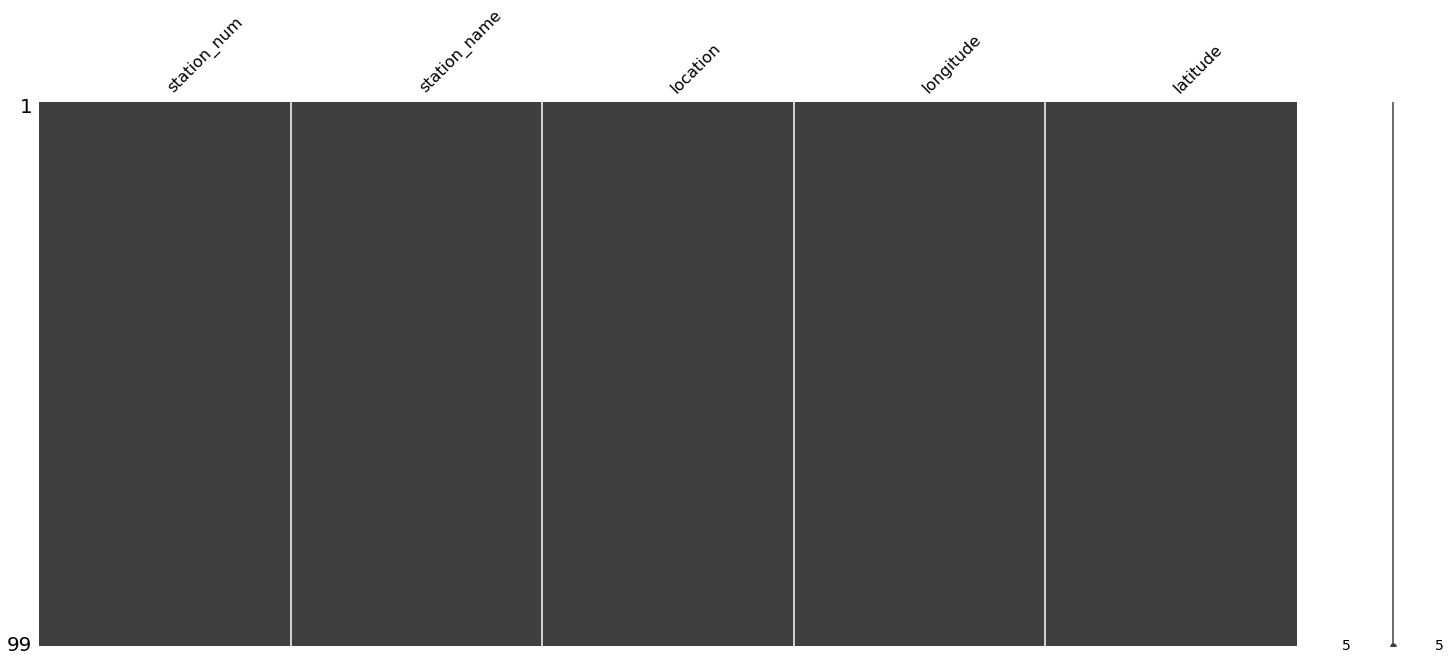

In [129]:
msno.matrix(station)

# 이용데이터 결측치 확인

<AxesSubplot:>

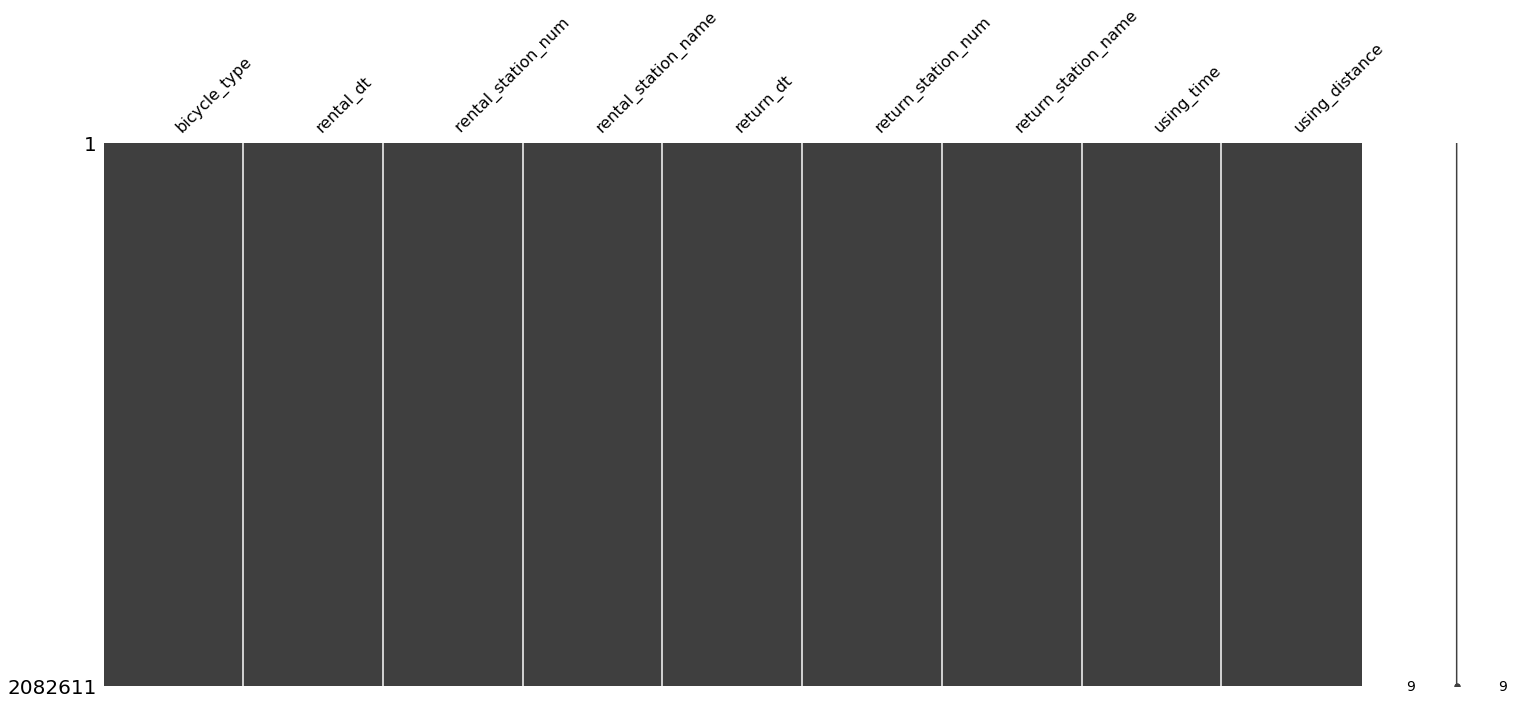

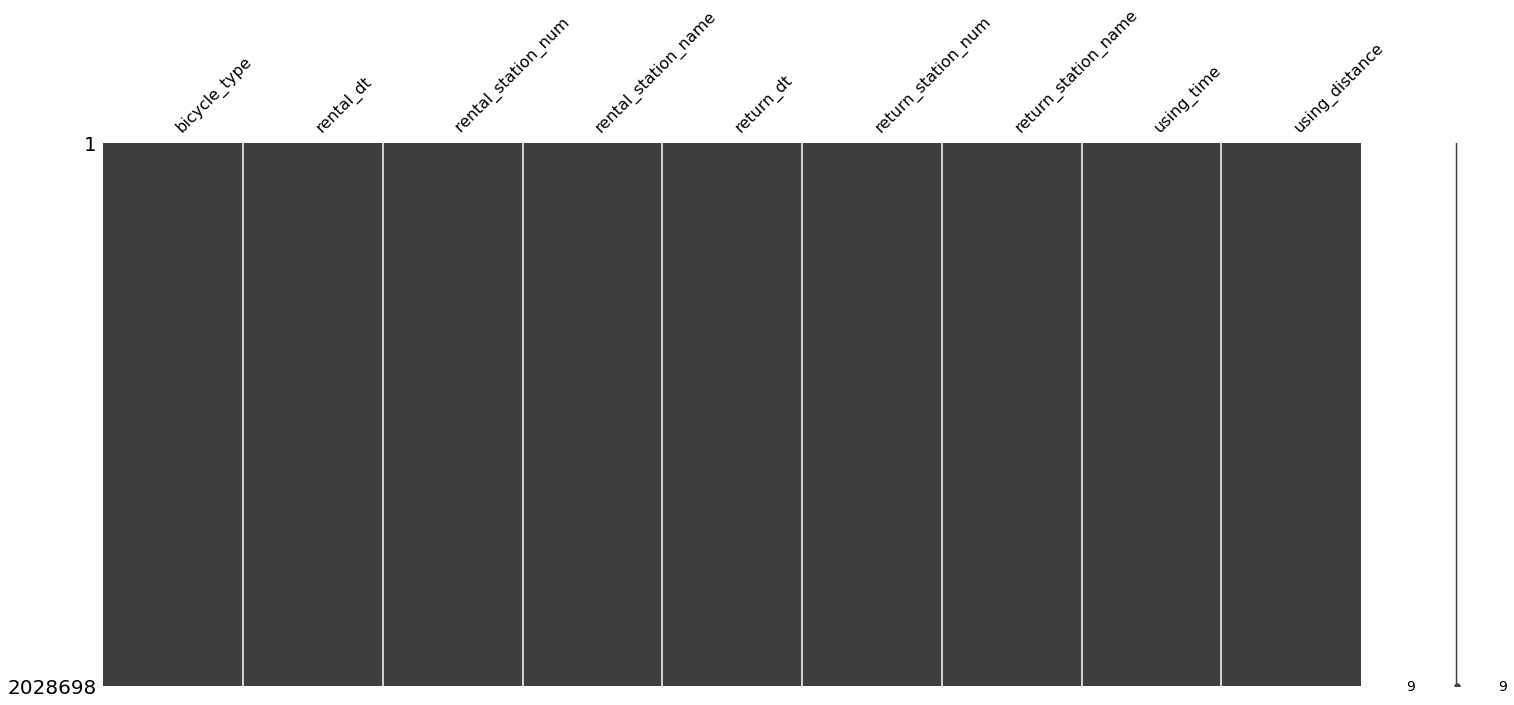

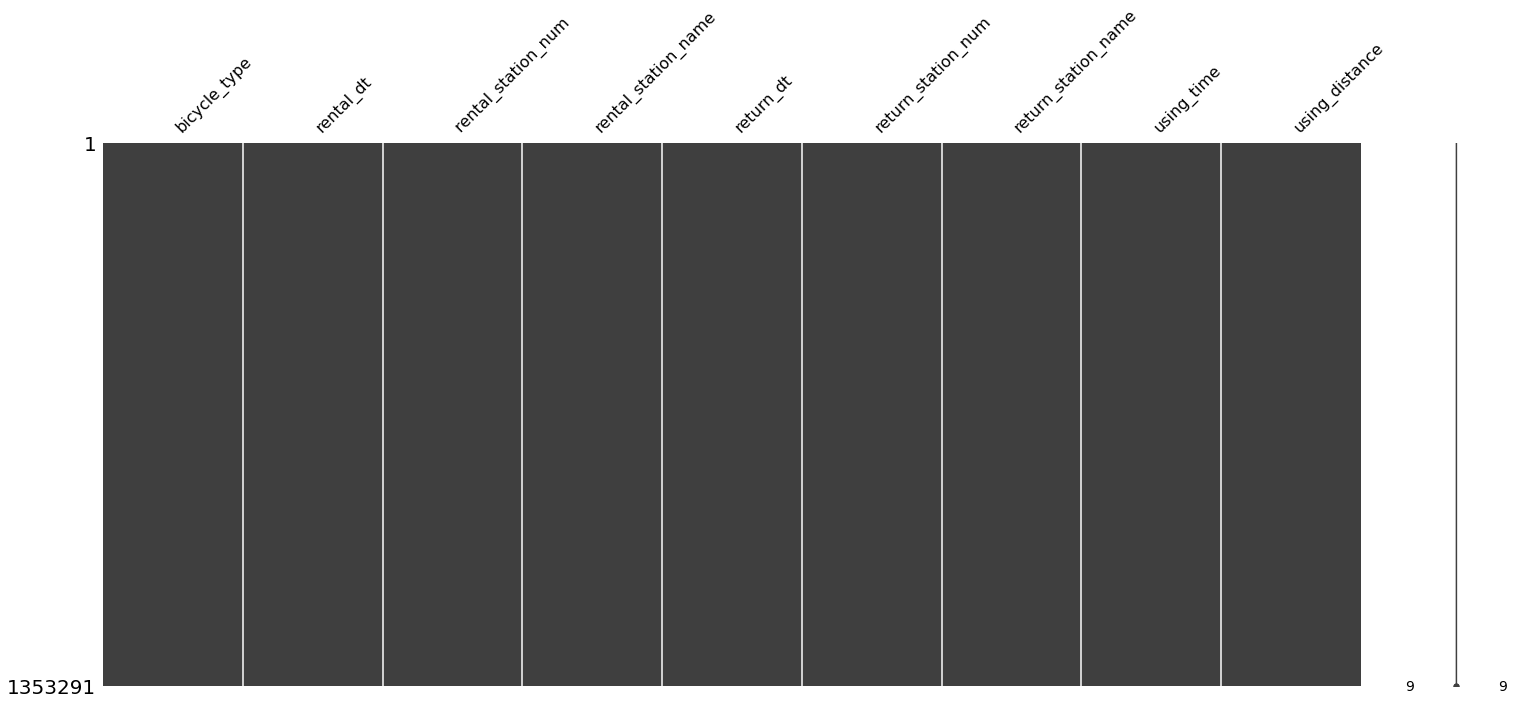

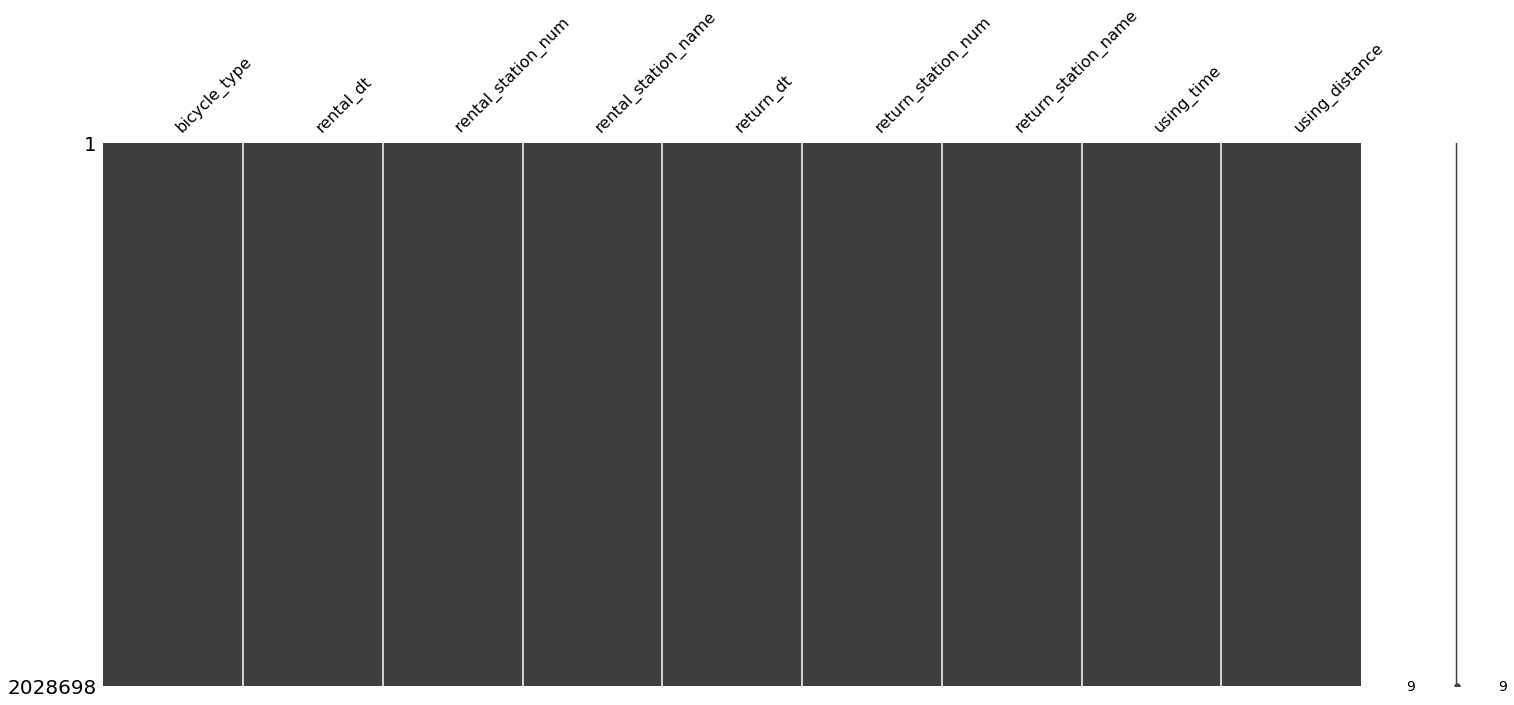

In [130]:
msno.matrix(sb1907)
msno.matrix(sb1908)
msno.matrix(sb2007)
msno.matrix(sb1908)

In [138]:
a = [1,2,3,4,5,6,7]
b = [7,8,9,10,11,10,9]
c = [1,1,2,2,3,3,3,3,4,4,5,5,6]

In [140]:
sb1908.groupby(sb1907['rental_station_num '])

/Users/riversong/opt/anaconda3/envs/dss/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ConversionError: Failed to convert value(s) to axis units: array([        bicycle_type            rental_dt  rental_station_num   \
       7          SPB-18746  2019-08-12 08:49:24                  529
       23         SPB-02914  2019-08-30 14:17:44                    3
       25         SPB-23817  2019-08-08 08:08:30                  194
       543563     SPB-05628  2019-08-23 22:54:53                  540
       543678     SPB-24895  2019-08-25 09:56:28                  571
       543680     SPB-24442  2019-08-25 11:25:53                 3502
       543732     SPB-03422  2019-08-25 21:27:48                  529
       543794     SPB-25393  2019-08-26 19:19:59                  562
       543906     SPB-12744  2019-08-27 19:03:45                 3518
       543963     SPB-19767  2019-08-28 18:15:32                 1450
       543965     SPB-09480  2019-08-28 18:30:59                  539
       544027     SPB-23958  2019-08-29 14:08:34                 3518
       544051     SPB-09886  2019-08-29 21:53:57                  383
       544097     SPB-20146  2019-08-30 17:34:20                  202
       544098     SPB-10193  2019-08-30 18:35:35                  419
       544205     SPB-15119  2019-08-01 11:23:24                  607
       544212     SPB-08457  2019-08-01 16:30:55                 3524
       544258     SPB-08113  2019-08-01 21:37:29                  500
       544291     SPB-14812  2019-08-02 16:24:10                 3517
       544393     SPB-18292  2019-08-04 02:47:49                 3509
       544561     SPB-13863  2019-08-06 21:09:28                  602
       544722     SPB-04791  2019-08-09 14:49:28                  571
       544831     SPB-16706  2019-08-10 21:57:15                  573
       1429303    SPB-09069  2019-08-19 09:54:24                 1661
       1429452    SPB-20720  2019-08-22 20:28:24                 1661
       1430232    SPB-23211  2019-08-11 03:03:01                 1722
       1431239    SPB-10059  2019-08-02 05:48:17                 1663
       1431380    SPB-15179  2019-08-03 21:26:05                 1663
       1431522    SPB-09215  2019-08-05 18:42:38                 1663
       1432129    SPB-03221  2019-08-13 11:05:51                 1548
       1432340    SPB-08389  2019-08-16 08:56:55                 1332
       1432588    SPB-14612  2019-08-18 22:14:36                 1534
       1432710    SPB-04079  2019-08-19 22:41:29                 1540
       1432776    SPB-02370  2019-08-20 17:06:27                 1683
       1451305    SPB-23772  2019-08-23 04:44:09                 1673
       1499096    SPB-23607  2019-08-22 22:13:44                 1546
       1499163    SPB-20668  2019-08-23 22:06:30                 1532
       1499228    SPB-21327  2019-08-24 20:06:01                 1509
       1499780    SPB-07133  2019-08-01 21:01:08                 1738
       1499827    SPB-10240  2019-08-02 20:09:31                 1716

               rental_station_name            return_dt  return_station_num  \
       7              장한평역 8번 출구 앞  2019-08-12 09:11:31                   3
       23                     중랑센터  2019-08-30 15:31:15                   3
       25                    증산교 앞  2019-08-08 08:21:29                   5
       543563      군자역 7번출구 베스트샵 앞  2019-08-23 23:05:01                 539
       543678          어린이대공원역6번출구  2019-08-25 10:17:54                 539
       543680             중곡역 1번출구  2019-08-25 11:37:35                 539
       543732         장한평역 8번 출구 앞  2019-08-25 22:16:55                 539
       543794             군자지하보도 앞  2019-08-26 20:29:34                 539
       543906            군자역 7번출구뒤  2019-08-27 22:04:46                 539
       543963            화랑대역 7번출구  2019-08-28 19:09:24                 539
       543965               군자교교차로  2019-08-28 19:22:20                 539
       544027            군자역 7번출구뒤  2019-08-29 15:12:23                 539
       544051         신당역 12번 출구 뒤  2019-08-29 22:26:18                 539
       544097               국민일보 앞  2019-08-30 20:32:17                 539
       544098               홈플러스 앞  2019-08-30 20:35:10                 539
       544205            신이문역 2번출구  2019-08-01 11:49:33                 540
       544212                세종대학교  2019-08-01 16:36:01                 540
       544258       어린이대공원역 3번출구 앞  2019-08-01 21:50:14                 540
       544291                용마사거리  2019-08-02 16:40:18                 540
       544393             세종사이버대학교  2019-08-04 02:59:43                 540
       544561              장안동 사거리  2019-08-06 21:22:58                 540
       544722          어린이대공원역6번출구  2019-08-09 14:55:18                 540
       544831             구의문주차장 앞  2019-08-10 22:04:22                 540
       1429303             당현천근린공원  2019-08-19 11:38:00                1661
       1429452             당현천근린공원  2019-08-22 21:24:39                1661
       1430232            창동청소년수련관  2019-08-11 03:12:13                1662
       1431239            동해문화예술관앞  2019-08-02 06:03:20                1663
       1431380            동해문화예술관앞  2019-08-03 22:17:57                1663
       1431522            동해문화예술관앞  2019-08-05 19:33:19                1663
       1432129          북서울 꿈의숲 서문  2019-08-13 11:16:53                1663
       1432340        석계역 5번출구 건너편  2019-08-16 09:03:02                1663
       1432588         북서울 꿈의 숲 동문  2019-08-18 22:46:02                1663
       1432710                가오리역  2019-08-19 23:06:40                1663
       1432776            노원문화예술회관  2019-08-20 17:41:59                1663
       1451305            노원역?5번출구  2019-08-23 04:48:08                1674
       1499096              송천동우체국  2019-08-22 22:55:13                1737
       1499163        번3동 주민센터 교차로  2019-08-23 22:22:44                1737
       1499228           서울북부수도사업소  2019-08-24 20:17:34                1737
       1499780        창동주공17단지 상가앞  2019-08-01 21:25:58                1738
       1499827           하나로마트 창동점  2019-08-02 20:18:56                1738

               return_station_name  using_time  using_distance
       7                      중랑센터          20          1220.0
       23                     중랑센터          73             0.0
       25                 상암센터 정비실          12          1860.0
       543563               군자교교차로           9           750.0
       543678               군자교교차로          20          1620.0
       543680               군자교교차로          11          1800.0
       543732               군자교교차로          48          7610.0
       543794               군자교교차로          66         59690.0
       543906               군자교교차로         170           450.0
       543963               군자교교차로          49          8000.0
       543965               군자교교차로          49          1230.0
       544027               군자교교차로          62         11280.0
       544051               군자교교차로          31          5890.0
       544097               군자교교차로         169         24880.0
       544098               군자교교차로         113         11200.0
       544205      군자역 7번출구 베스트샵 앞          25             0.0
       544212      군자역 7번출구 베스트샵 앞           4          1030.0
       544258      군자역 7번출구 베스트샵 앞          12          1430.0
       544291      군자역 7번출구 베스트샵 앞          15          1630.0
       544393      군자역 7번출구 베스트샵 앞          11          1140.0
       544561      군자역 7번출구 베스트샵 앞          13             0.0
       544722      군자역 7번출구 베스트샵 앞           5           950.0
       544831      군자역 7번출구 베스트샵 앞           6             0.0
       1429303             당현천근린공원          97          5000.0
       1429452             당현천근린공원          51         45110.0
       1430232             노원역7번출구           9          1410.0
       1431239            동해문화예술관앞          14          2070.0
       1431380            동해문화예술관앞          51         12020.0
       1431522            동해문화예술관앞          49          3350.0
       1432129            동해문화예술관앞          10          3130.0
       1432340            동해문화예술관앞           5          1000.0
       1432588            동해문화예술관앞          30          5180.0
       1432710            동해문화예술관앞          24          5420.0
       1432776            동해문화예술관앞          35          5720.0
       1451305           서울북부고용센터앞           3           290.0
       1499096          하나은행 (창동점)          41          3710.0
       1499163          하나은행 (창동점)          15          2160.0
       1499228          하나은행 (창동점)          10          1030.0
       1499780        창동주공17단지 상가앞          24          3270.0
       1499827        창동주공17단지 상가앞           8          1020.0                ,
              bicycle_type            rental_dt  rental_station_num   \
       464501    SPB-14614  2019-08-23 08:18:45                  146

              rental_station_name            return_dt  return_station_num  \
       464501          마포역 2번출구 뒤  2019-08-23 08:22:18                 439

              return_station_name  using_time  using_distance
       464501             마포어린이공원           3           670.0                ,
               bicycle_type            rental_dt  rental_station_num   \
       377557     SPB-21734  2019-08-15 01:09:52                  327
       495956     SPB-14462  2019-08-03 17:41:50                  548
       495957     SPB-06758  2019-08-03 17:47:27                 3533
       504352     SPB-07174  2019-08-27 12:11:53                  583
       512460     SPB-23743  2019-08-05 18:31:32                  582
       557197     SPB-16619  2019-08-20 19:13:56                  521
       570850     SPB-17036  2019-08-30 19:01:06                  536
       599372     SPB-13349  2019-08-07 02:00:41                  540
       603318     SPB-18263  2019-08-03 22:38:48                 1641
       615412     SPB-12985  2019-08-16 22:19:14                  540
       621602     SPB-13823  2019-08-20 12:48:11                  591
       632452     SPB-05847  2019-08-19 16:23:22                  652
       669586     SPB-21385  2019-08-28 23:32:40                 3510
       673228     SPB-19321  2019-08-21 21:50:40                 1319
       688713     SPB-15799  2019-08-09 19:44:49                  650
       708536     SPB-21493  2019-08-31 16:20:00                  716
       714381     SPB-24874  2019-08-14 22:24:00                 1988
       1104194    SPB-11254  2019-08-18 00:47:57                 1235
       1142337    SPB-23013  2019-08-25 21:38:59                 2361
       1205550    SPB-15545  2019-08-17 20:57:54                 1293
       1286843    SPB-17537  2019-08-01 21:09:18                 1455
       1970866    SPB-15975  2019-08-15 21:39:23                  503
       2015743    SPB-10490  2019-08-26 11:34:34                 3534

               rental_station_name            return_dt  return_station_num  \
       377557               낙원상가 옆  2019-08-15 01:24:17                 354
       495956                자양나들목  2019-08-03 17:43:49                 504
       495957     건대입구역 사거리(롯데백화점)  2019-08-03 18:04:42                 504
       504352           청계천 생태교실 앞  2019-08-27 12:55:16                 506
       512460              경일중학교 앞  2019-08-05 18:38:05                 511
       557197        왕십리역 11번 출구 앞  2019-08-20 19:52:13                 549
       570850           행당역 2번출구 앞  2019-08-30 19:08:11                 559
       599372      군자역 7번출구 베스트샵 앞  2019-08-07 02:22:44                 579
       603318            한내근린공원 남측  2019-08-03 23:29:27                 583
       615412      군자역 7번출구 베스트샵 앞  2019-08-16 22:45:23                 588
       621602          건국대학교 (행정관)  2019-08-20 12:50:22                 590
       632452     답십리 래미안엘파인아파트 입구  2019-08-19 16:31:57                 602
       669586             중곡SK아파트앞  2019-08-29 00:02:11                 634
       673228            종암사거리 분수대  2019-08-21 22:04:31                 637
       688713               중랑교사거리  2019-08-09 20:40:34                 650
       708536         신정6동 주민센터 인근  2019-08-31 16:30:50                 703
       714381          고척LIGA아파트 앞  2019-08-14 22:35:13                 708
       1104194        잠실트리지움310동 옆  2019-08-18 00:58:58                1211
       1142337            압구정역 교차로  2019-08-25 22:31:14                1235
       1205550     석촌호교차로 (스타벅스 앞)  2019-08-17 21:41:04                1295
       1286843           상봉역 2번 출구  2019-08-01 21:13:58                1411
       1970866         더샵스타시티 C동 앞  2019-08-15 21:54:10                3508
       2015743        건대입구역 5번출구 뒤  2019-08-26 13:08:54                3534

               return_station_name  using_time  using_distance
       377557           포르투갈 대사관 앞          13          1460.0
       495956            신자초교입구교차로           1           380.0
       495957            신자초교입구교차로          16          1230.0
       504352         금호 어울림 아파트 앞          43          4940.0
       512460         서울숲역 4번 출구 옆           6           720.0
       557197            아차산역 3번출구          37          6630.0
       570850       왕십리역 4번 출구 건너편           6           960.0
       599372             마장역 4번출구          21          4320.0
       603318           청계천 생태교실 앞          50         17960.0
       615412              뚝섬 유원지역          25          4560.0
       621602        건국대학교 (입학정보관)           1           520.0
       632452              장안동 사거리           8          1190.0
       669586            외국어대 정문 앞          27          4450.0
       673228         KAIST 경영대학 앞          13          2460.0
       688713               중랑교사거리          55          9440.0
       708536          오목교역 7번출구 앞          10          1570.0
       714381         서울출입국관리사무소 앞          10          2270.0
       1104194               방이삼거리          10          2120.0
       1142337        잠실트리지움310동 옆          52          8370.0
       1205550            잠실역 8번출구          42          4490.0
       1286843    상봉시장앞 교차로 한성빌딩 앞           4           460.0
       1970866               화양사거리          14          2030.0
       2015743        건대입구역 5번출구 뒤          90          6290.0                ,
       ...,
               bicycle_type            rental_dt  rental_station_num   \
       1074549    SPB-24644  2019-08-16 16:34:18                 1158
       1074552    SPB-12358  2019-08-16 16:41:54                 1182
       1074592    SPB-08221  2019-08-16 21:00:35                 1106
       1074595    SPB-03619  2019-08-16 21:22:59                 1113
       1074597    SPB-18295  2019-08-16 21:25:38                 1113
       1074642    SPB-13075  2019-08-17 15:24:04                 2701
       1074643    SPB-24282  2019-08-17 14:25:48                 1113
       1074644    SPB-17640  2019-08-17 15:42:12                 1167
       1074645    SPB-17583  2019-08-17 15:42:11                 1167
       1074697    SPB-05155  2019-08-17 19:41:44                 2701
       1074698    SPB-07502  2019-08-17 20:14:46                 2701
       1074699    SPB-14973  2019-08-17 20:00:04                 1113
       1074700    SPB-11239  2019-08-17 20:03:01                 1126
       1074747    SPB-14966  2019-08-18 12:50:01                 2701
       1074854    SPB-19122  2019-08-19 08:58:34                 1126
       1074855    SPB-06706  2019-08-19 08:59:51                 1152
       1074856    SPB-16627  2019-08-19 09:05:03                 1173
       1074910    SPB-21284  2019-08-19 18:51:06                  249
       1074911    SPB-22522  2019-08-19 19:31:45                 2701
       1074912    SPB-16450  2019-08-19 19:38:08                 1168
       1074913    SPB-16304  2019-08-19 19:26:43                 1190
       1074914    SPB-11296  2019-08-19 19:26:49                 1190
       1074964    SPB-22929  2019-08-20 08:01:15                 2701
       1075115    SPB-14600  2019-08-21 09:19:13                 1125
       1075183    SPB-22971  2019-08-22 06:30:04                 1167
       1075270    SPB-15116  2019-08-22 19:36:55                 1112
       1075271    SPB-24316  2019-08-22 19:49:34                 1126
       1075359    SPB-12365  2019-08-23 14:39:27                 1166
       1075392    SPB-05684  2019-08-23 18:39:54                 1160
       1075448    SPB-16148  2019-08-24 02:36:48                 1151
       1075498    SPB-03188  2019-08-24 15:13:05                 1112
       1075499    SPB-03772  2019-08-24 15:05:56                 1185
       1075523    SPB-17821  2019-08-24 18:36:54                 1191
       1075529    SPB-24704  2019-08-24 18:47:20                 1120
       1075546    SPB-16165  2019-08-24 19:49:28                 2701
       1075547    SPB-13404  2019-08-24 19:40:06                 2701

                     rental_station_name            return_dt  return_station_num  \
       1074549                  가양역 8번출구  2019-08-16 16:53:50                1197
       1074552                 KBS 스포츠월드  2019-08-16 17:06:36                1197
       1074592                    신방화사거리  2019-08-16 21:36:07                1197
       1074595              서남환경공원 버스정류장  2019-08-16 22:18:50                1197
       1074597              서남환경공원 버스정류장  2019-08-16 22:19:08                1197
       1074642             마곡나루역 5번출구 뒤편  2019-08-17 15:37:48                1197
       1074643              서남환경공원 버스정류장  2019-08-17 15:42:32                1197
       1074644            마곡수명산파크3단지 교차로  2019-08-17 15:50:46                1197
       1074645            마곡수명산파크3단지 교차로  2019-08-17 15:50:50                1197
       1074697             마곡나루역 5번출구 뒤편  2019-08-17 20:11:56                1197
       1074698             마곡나루역 5번출구 뒤편  2019-08-17 20:21:35                1197
       1074699              서남환경공원 버스정류장  2019-08-17 20:26:11                1197
       1074700  우장산역 1번출구옆(우장산아이파크105동앞)  2019-08-17 20:53:27                1197
       1074747             마곡나루역 5번출구 뒤편  2019-08-18 12:59:54                1197
       1074854  우장산역 1번출구옆(우장산아이파크105동앞)  2019-08-19 09:05:41                1197
       1074855                    마곡역교차로  2019-08-19 09:08:35                1197
       1074856             강서구청사거리(SH타워)  2019-08-19 09:15:34                1197
       1074910                  여의도중학교 옆  2019-08-19 19:36:59                1197
       1074911             마곡나루역 5번출구 뒤편  2019-08-19 19:39:17                1197
       1074912               마곡엠밸리10단지 앞  2019-08-19 19:46:52                1197
       1074913             마곡역 교차로(2번출구)  2019-08-19 19:47:19                1197
       1074914             마곡역 교차로(2번출구)  2019-08-19 19:47:27                1197
       1074964             마곡나루역 5번출구 뒤편  2019-08-20 08:07:08                1197
       1075115              명덕고교입구(영종빌딩)  2019-08-21 09:27:10                1197
       1075183            마곡수명산파크3단지 교차로  2019-08-22 06:37:48                1197
       1075270               마곡엠밸리4단지 정문  2019-08-22 19:50:21                1197
       1075271  우장산역 1번출구옆(우장산아이파크105동앞)  2019-08-22 19:57:07                1197
       1075359                 강서구립등빛도서관  2019-08-23 14:44:32                1197
       1075392               양천향교역 7번출구앞  2019-08-23 18:47:03                1197
       1075448                   마곡역1번출구  2019-08-24 03:10:25                1197
       1075498               마곡엠밸리4단지 정문  2019-08-24 15:25:56                1197
       1075499                     등촌9단지  2019-08-24 15:37:46                1197
       1075523             마곡역 교차로(NH농협)  2019-08-24 18:42:00                1197
       1075529                  대림경동아파트앞  2019-08-24 19:06:59                1197
       1075546             마곡나루역 5번출구 뒤편  2019-08-24 20:25:36                1197
       1075547             마곡나루역 5번출구 뒤편  2019-08-24 20:26:55                1197

               return_station_name  using_time  using_distance
       1074549         엘펠리체 호텔 건너편          18          3520.0
       1074552         엘펠리체 호텔 건너편          23          4200.0
       1074592         엘펠리체 호텔 건너편          33          3840.0
       1074595         엘펠리체 호텔 건너편          55          6030.0
       1074597         엘펠리체 호텔 건너편          53          3940.0
       1074642         엘펠리체 호텔 건너편          13          1300.0
       1074643         엘펠리체 호텔 건너편          76          4770.0
       1074644         엘펠리체 호텔 건너편           8          1670.0
       1074645         엘펠리체 호텔 건너편           8          1690.0
       1074697         엘펠리체 호텔 건너편          29          1400.0
       1074698         엘펠리체 호텔 건너편           6           920.0
       1074699         엘펠리체 호텔 건너편          25          2760.0
       1074700         엘펠리체 호텔 건너편          48          5140.0
       1074747         엘펠리체 호텔 건너편           9          1320.0
       1074854         엘펠리체 호텔 건너편           6          1610.0
       1074855         엘펠리체 호텔 건너편           8          1050.0
       1074856         엘펠리체 호텔 건너편          10          1810.0
       1074910         엘펠리체 호텔 건너편          42         11830.0
       1074911         엘펠리체 호텔 건너편           7          1260.0
       1074912         엘펠리체 호텔 건너편           8          1770.0
       1074913         엘펠리체 호텔 건너편          20          2200.0
       1074914         엘펠리체 호텔 건너편          19          1740.0
       1074964         엘펠리체 호텔 건너편           5          1300.0
       1075115         엘펠리체 호텔 건너편           7          1140.0
       1075183         엘펠리체 호텔 건너편           7          1500.0
       1075270         엘펠리체 호텔 건너편          13          1970.0
       1075271         엘펠리체 호텔 건너편           7          1590.0
       1075359         엘펠리체 호텔 건너편           4           730.0
       1075392         엘펠리체 호텔 건너편           6          1200.0
       1075448         엘펠리체 호텔 건너편          33          3950.0
       1075498         엘펠리체 호텔 건너편          12          1980.0
       1075499         엘펠리체 호텔 건너편          31          1990.0
       1075523         엘펠리체 호텔 건너편           4           910.0
       1075529         엘펠리체 호텔 건너편          18          2720.0
       1075546         엘펠리체 호텔 건너편          35          3820.0
       1075547         엘펠리체 호텔 건너편          46          4120.0                      ,
               bicycle_type            rental_dt  rental_station_num   \
       901084     SPB-20316  2019-08-11 18:21:31                 1269
       908361     SPB-09871  2019-08-27 18:10:44                 1267
       919336     SPB-10159  2019-08-05 15:34:23                 1050
       932285     SPB-11777  2019-08-25 16:45:12                 1060
       948157     SPB-00562  2019-08-09 18:37:01                 1008
       964705     SPB-13225  2019-08-06 18:16:41                 1160
       1074550    SPB-24214  2019-08-16 16:01:20                 1196
       1074551    SPB-19345  2019-08-16 16:01:26                 1196
       1074596    SPB-19184  2019-08-16 21:26:45                 1113
       1811335    SPB-11974  2019-08-27 19:28:29                 2242
       1811813    SPB-15804  2019-08-13 09:50:45                 2266
       1830696    SPB-11963  2019-08-25 03:15:18                 2353
       1831096    SPB-14208  2019-08-18 12:56:17                 2342
       1957732    SPB-16104  2019-08-05 02:47:32                  419
       1957807    SPB-10461  2019-08-09 18:41:13                  110
       1957808    SPB-25046  2019-08-09 19:35:56                  114

               rental_station_name            return_dt  return_station_num  \
       901084               리센츠아파트  2019-08-11 18:45:52                1018
       908361          올림픽공원 남2문 앞  2019-08-27 18:22:16                1020
       919336           둔촌역 3번 출입구  2019-08-05 15:44:55                1029
       932285             천일초교 사거리  2019-08-25 16:51:28                1044
       948157      암사역 3번출구(국민은행앞)  2019-08-09 18:42:31                1061
       964705          양천향교역 7번출구앞  2019-08-06 18:27:19                1117
       1074550     서울식물원(문화센터) 건너편  2019-08-16 16:57:44                1197
       1074551     서울식물원(문화센터) 건너편  2019-08-16 17:05:34                1197
       1074596        서남환경공원 버스정류장  2019-08-16 22:18:58                1197
       1811335        양재역 11번 출구 앞  2019-08-27 20:11:05                2279
       1811813            서초역 3번출구  2019-08-13 10:08:49                2280
       1830696        강남구청역 2번출구 뒤  2019-08-25 03:25:24                2308
       1831096         대청역 1번출구  뒤  2019-08-18 13:33:41                2309
       1957732              홈플러스 앞  2019-08-05 03:21:17                3107
       1957807                 사천교  2019-08-09 18:57:41                3107
       1957808        홍대입구역 8번출구 앞  2019-08-09 20:00:56                3107

               return_station_name  using_time  using_distance
       901084         둔촌 주공 GS 맞은편          22          5790.0
       908361                강동경찰서          10          2080.0
       919336               롯데 시네마          10          1850.0
       932285                굽은다리역           6          1150.0
       948157    천호초교 입구 사거리(일주빌딩)           5           870.0
       964705                스타벅스앞          10          1480.0
       1074550         엘펠리체 호텔 건너편          56          1610.0
       1074551         엘펠리체 호텔 건너편          63          2370.0
       1074596         엘펠리체 호텔 건너편          51          3490.0
       1811335           교대역 5번출구뒤          38          2910.0
       1811813           서울서초고용센터앞          17          3750.0
       1830696            압구정파출소 앞           9          1480.0
       1831096        청담역(우리들병원 앞)          37          5370.0
       1957732            연희초등학교 앞          33          4790.0
       1957807            연희초등학교 앞          16          1800.0
       1957808            연희초등학교 앞          24          1920.0                ,
              bicycle_type            rental_dt  rental_station_num   \
       218494    SPB-13619  2019-08-26 11:55:11                  232

              rental_station_name            return_dt  return_station_num  \
       218494        양평우림 이비즈센타 앞  2019-08-26 12:00:46                 230

              return_station_name  using_time  using_distance
       218494         영등포구청역 1번출구           5           830.0                ],
      dtype=object)

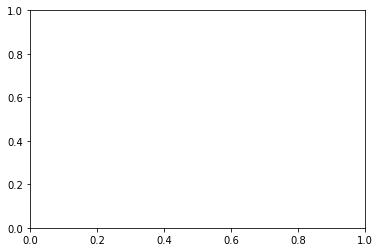

In [141]:
grouped = plt.plot(sb1908.groupby(sb1907['rental_station_num ']),)
grouped.count()

In [137]:
sb1907[sb1907['retal_station_num'] in mapo]

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),2019-07-02 08:42:31,3,중랑센터,6,1350.0
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2019-07-03 08:42:28,3,중랑센터,7,1160.0
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2019-07-03 09:09:44,3,중랑센터,23,1270.0
3,SPB-21930,2019-07-04 08:49:57,646,장한평역 1번출구 (국민은행앞),2019-07-04 09:04:17,3,중랑센터,14,1290.0
4,SPB-17709,2019-07-05 08:45:03,529,장한평역 8번 출구 앞,2019-07-05 09:11:47,3,중랑센터,26,1200.0
...,...,...,...,...,...,...,...,...,...
2082606,SPB-20127,2019-07-19 07:41:34,240,문래역 4번출구 앞,2019-07-19 07:51:55,9998,영남주차장 정비센터,9,480.0
2082607,SPB-23276,2019-07-19 07:50:48,832,이촌1동 주민센터 뒤,2019-07-19 08:32:51,9998,영남주차장 정비센터,40,8840.0
2082608,SPB-17321,2019-07-22 12:43:22,266,영등포청과시장 사거리,2019-07-22 13:07:29,9998,영남주차장 정비센터,23,3320.0
2082609,SPB-22044,2019-07-22 12:43:13,266,영등포청과시장 사거리,2019-07-22 13:08:53,9998,영남주차장 정비센터,25,2960.0


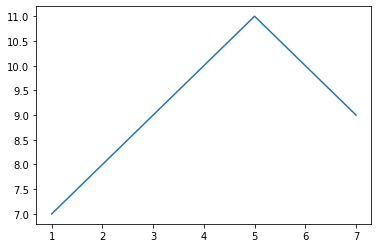

In [136]:
plt.plot(a,b)

In [186]:
sb1908

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-25398,2019-07-01 19:38:52,101,(구)합정동 주민센터,2019-07-01 20:36:41,101,(구)합정동 주민센터,55,8670.0
1,SPB-03998,2019-07-01 23:44:19,112,극동방송국 앞,2019-07-01 23:56:10,101,(구)합정동 주민센터,11,1880.0
2,SPB-05637,2019-07-02 02:12:10,151,망원1동주민센터,2019-07-02 02:17:09,101,(구)합정동 주민센터,4,1050.0
3,SPB-03483,2019-07-02 02:30:54,103,망원역 2번출구 앞,2019-07-02 02:36:30,101,(구)합정동 주민센터,5,1110.0
4,SPB-20645,2019-07-02 01:41:58,108,서교동 사거리,2019-07-02 02:41:14,101,(구)합정동 주민센터,55,1740.0
...,...,...,...,...,...,...,...,...,...
82034,SPB-19576,2019-07-12 18:36:48,113,홍대입구역 2번출구 앞,2019-07-12 20:21:19,3533,건대입구역 사거리(롯데백화점),102,20190.0
82035,SPB-06265,2019-07-11 21:25:59,112,극동방송국 앞,2019-07-11 23:08:52,3534,건대입구역 5번출구 뒤,102,19730.0
82036,SPB-22456,2019-07-06 21:43:10,129,신촌역(2호선) 6번출구 옆,2019-07-06 23:10:52,3535,중곡사거리(국민은행),87,19870.0
82037,SPB-23712,2019-07-02 21:09:45,118,광흥창역 2번출구 앞,2019-07-02 22:49:08,3536,중앙농협(자양동),95,81590.0


In [11]:
# df 저장하기
# time_pd.to_csv("filename.csv", mode='w')

In [258]:
sb2007

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-11402,2020-07-01,610,동대문중 교차로,2020-07-01 00:03:23,657,동대문롯데캐슬아파트 앞,3,450.00
1,SPB-32502,2020-07-01,1707,도봉구민회관,2020-07-01 00:04:30,1775,신원리베르텔 앞,4,0.00
2,SPB-33694,2020-07-01,2312,청담역 13번 출구 앞,2020-07-01 00:05:10,2313,금원빌딩 앞,5,492.63
3,SPB-32022,2020-07-01,2724,(재)FITI시험연구원,2020-07-01 00:05:24,2724,(재)FITI시험연구원,3,0.00
4,SPB-31475,2020-07-01,1436,영풍마드레빌,2020-07-01 00:05:35,1402,금란주차장 앞,4,222.39
...,...,...,...,...,...,...,...,...,...
1353286,SPB-34167,2020-07-31 23:40:19,2524,반포쇼핑타운 8동 앞,2020-08-01 00:03:42,837,한남나들목 입구,23,0.00
1353287,SPB-32240,2020-07-31 22:53:36,475,유어스,2020-08-01 00:03:42,475,유어스,70,0.00
1353288,SPB-30784,2020-07-31 22:50:33,787,양천아파트 입구,2020-08-01 00:03:43,787,양천아파트 입구,73,0.00
1353289,SPB-31697,2020-07-31 23:55:52,559,왕십리역 4번 출구 건너편,2020-08-01 00:03:44,519,양지사거리,8,0.00


In [305]:
test = sb2007_08[:200]

In [263]:
test

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance
0,SPB-11402,2020-07-01 00:00:15,610,동대문중 교차로,2020-07-01 00:03:23,657,동대문롯데캐슬아파트 앞,3,450.00
1,SPB-32502,2020-07-01 00:00:40,1707,도봉구민회관,2020-07-01 00:04:30,1775,신원리베르텔 앞,4,0.00
2,SPB-33694,2020-07-01 00:00:17,2312,청담역 13번 출구 앞,2020-07-01 00:05:10,2313,금원빌딩 앞,5,492.63
3,SPB-32022,2020-07-01 00:02:07,2724,(재)FITI시험연구원,2020-07-01 00:05:24,2724,(재)FITI시험연구원,3,0.00
4,SPB-31475,2020-07-01 00:01:56,1436,영풍마드레빌,2020-07-01 00:05:35,1402,금란주차장 앞,4,222.39
...,...,...,...,...,...,...,...,...,...
195,SPB-11189,2020-07-01 00:08:02,3106,홍남교 두바퀴쉼터,2020-07-01 00:26:09,113,홍대입구역 2번출구 앞,17,2300.00
196,SPB-12390,2020-07-01 00:16:40,161,무악재역1번 출구,2020-07-01 00:26:13,117,홍은사거리,8,1360.00
197,SPB-32146,2020-07-01 00:12:21,926,불광역 8번출구,2020-07-01 00:26:17,949,연신내역 1번 출구,14,1882.59
198,SPB-30158,2020-07-01 00:21:47,2732,마곡수명산 1-2단지,2020-07-01 00:26:19,1191,마곡역 교차로(NH농협),5,310.54


In [17]:
def split_dt(df):
    # rent_dt & return_dt 를 split으로 날짜와 시간을 분리
    rent_D = df['rental_dt'].str.split(' ').str[0]
    rent_T = df['rental_dt'].str.split(' ').str[1] 
    return_D = df['return_dt'].str.split(' ').str[0]
    return_T = df['return_dt'].str.split(' ').str[1]
    # bicycle의 타입을 알기 위해 split으로 분리 후 넘버만 저장
    bicycle_num = df['bicycle_type'].str.split('-').str[1]
    
    
    df['rental_day'] = rent_D
    df['rental_time'] = rent_T
    df['return_day'] = return_D
    df['return_time'] = return_T
    df['bicycle_type_num'] = bicycle_num
    
#     df = df.drop('rental_dt',axis=1)
#     df = df.drop('return_dt',axis=1)
#     df = df.drop('bicycle_type',axis=1)
    return df


In [18]:
# sb1907_1 = using_change(sb1907_1)
split_dt(sb1907_1)
sb1907_1

,bicycle_type,rental_dt,rental_station_num,rental_station_name,return_dt,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,return_time,bicycle_type_num
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),2019-07-02 08:42:31,3,중랑센터,6,1350.0,2019-07-02,08:35:17,2019-07-02,08:42:31,21789
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2019-07-03 08:42:28,3,중랑센터,7,1160.0,2019-07-03,08:35:06,2019-07-03,08:42:28,22363
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2019-07-03 09:09:44,3,중랑센터,23,1270.0,2019-07-03,08:46:07,2019-07-03,09:09:44,24965
3,SPB-21930,2019-07-04 08:49:57,646,장한평역 1번출구 (국민은행앞),2019-07-04 09:04:17,3,중랑센터,14,1290.0,2019-07-04,08:49:57,2019-07-04,09:04:17,21930
4,SPB-17709,2019-07-05 08:45:03,529,장한평역 8번 출구 앞,2019-07-05 09:11:47,3,중랑센터,26,1200.0,2019-07-05,08:45:03,2019-07-05,09:11:47,17709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,SPB-11568,2019-07-22 20:28:29,844,이촌2동 동원베네스트 아파트 앞,2019-07-22 20:42:38,823,효창동주민센터 앞,14,2370.0,2019-07-22,20:28:29,2019-07-22,20:42:38,11568
799996,SPB-24122,2019-07-22 20:19:27,119,서강나루 공원,2019-07-22 20:44:40,823,효창동주민센터 앞,24,4450.0,2019-07-22,20:19:27,2019-07-22,20:44:40,24122
799997,SPB-22506,2019-07-22 21:32:46,819,선린인터넷 고등학교,2019-07-22 21:41:25,823,효창동주민센터 앞,8,1170.0,2019-07-22,21:32:46,2019-07-22,21:41:25,22506
799998,SPB-24122,2019-07-22 21:09:04,823,효창동주민센터 앞,2019-07-22 23:04:52,823,효창동주민센터 앞,112,8960.0,2019-07-22,21:09:04,2019-07-22,23:04:52,24122


In [306]:
split_dt(test)

/Users/riversong/opt/anaconda3/envs/dss/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/riversong/opt/anaconda3/envs/dss/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/riversong/opt/anaconda3/envs/dss/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,bicycle_type,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,return_time
0,SPB-11402,610,동대문중 교차로,657,동대문롯데캐슬아파트 앞,3,450.00,2020-07-01,00:00:15,2020-07-01,00:03:23
1,SPB-32502,1707,도봉구민회관,1775,신원리베르텔 앞,4,0.00,2020-07-01,00:00:40,2020-07-01,00:04:30
2,SPB-33694,2312,청담역 13번 출구 앞,2313,금원빌딩 앞,5,492.63,2020-07-01,00:00:17,2020-07-01,00:05:10
3,SPB-32022,2724,(재)FITI시험연구원,2724,(재)FITI시험연구원,3,0.00,2020-07-01,00:02:07,2020-07-01,00:05:24
4,SPB-31475,1436,영풍마드레빌,1402,금란주차장 앞,4,222.39,2020-07-01,00:01:56,2020-07-01,00:05:35
...,...,...,...,...,...,...,...,...,...,...,...
195,SPB-11189,3106,홍남교 두바퀴쉼터,113,홍대입구역 2번출구 앞,17,2300.00,2020-07-01,00:08:02,2020-07-01,00:26:09
196,SPB-12390,161,무악재역1번 출구,117,홍은사거리,8,1360.00,2020-07-01,00:16:40,2020-07-01,00:26:13
197,SPB-32146,926,불광역 8번출구,949,연신내역 1번 출구,14,1882.59,2020-07-01,00:12:21,2020-07-01,00:26:17
198,SPB-30158,2732,마곡수명산 1-2단지,1191,마곡역 교차로(NH농협),5,310.54,2020-07-01,00:21:47,2020-07-01,00:26:19


In [22]:
def column_drop(df):
    df = df.drop('rental_dt',axis=1)
    df = df.drop('return_dt',axis=1)
    df = df.drop('bicycle_type',axis=1)
    return df

In [23]:
column_drop(sb1907_1)
sb1907_1

KeyError: "['bicycle_type'] not found in axis"

In [288]:
test = test.drop('rental_dt',axis=1)
test = test.drop('return_dt',axis=1)

In [289]:
test

,bicycle_type,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,return_time
0,SPB-11402,610,동대문중 교차로,657,동대문롯데캐슬아파트 앞,3,450.00,2020-07-01,00:00:15,2020-07-01,00:03:23
1,SPB-32502,1707,도봉구민회관,1775,신원리베르텔 앞,4,0.00,2020-07-01,00:00:40,2020-07-01,00:04:30
2,SPB-33694,2312,청담역 13번 출구 앞,2313,금원빌딩 앞,5,492.63,2020-07-01,00:00:17,2020-07-01,00:05:10
3,SPB-32022,2724,(재)FITI시험연구원,2724,(재)FITI시험연구원,3,0.00,2020-07-01,00:02:07,2020-07-01,00:05:24
4,SPB-31475,1436,영풍마드레빌,1402,금란주차장 앞,4,222.39,2020-07-01,00:01:56,2020-07-01,00:05:35
...,...,...,...,...,...,...,...,...,...,...,...
195,SPB-11189,3106,홍남교 두바퀴쉼터,113,홍대입구역 2번출구 앞,17,2300.00,2020-07-01,00:08:02,2020-07-01,00:26:09
196,SPB-12390,161,무악재역1번 출구,117,홍은사거리,8,1360.00,2020-07-01,00:16:40,2020-07-01,00:26:13
197,SPB-32146,926,불광역 8번출구,949,연신내역 1번 출구,14,1882.59,2020-07-01,00:12:21,2020-07-01,00:26:17
198,SPB-30158,2732,마곡수명산 1-2단지,1191,마곡역 교차로(NH농협),5,310.54,2020-07-01,00:21:47,2020-07-01,00:26:19


In [ ]:
def bicycle_type_to_num(df):
    if 

   - 00001 ~ 10000 : 초기형 
   - 10001 ~ 20000 : 후기형
   - 20001 ~ 27000 : 개선형
   - 30001 ~       : QR단말기(뉴따릉이)형
   - 80001 ~       : 새싹따릉이 : 청소년, 어르신 등도 편리하게 이용할 수 있도록 만든 모델

In [ ]:
'''
데이터 컬럼명을 영어로 변환
안쓰는 컬럼 제거
마포구만 필터링
bicycle_type, dt 컬럼 분리 후 새로 붙이기
bicycle_type을 숫자로 변환
'''